This file is part of MADIP: Molecular Atlas Data Integration Pipeline

This file provide some additional nomenclature refinements and concentrations calculation


Copyright 2021 Blue Brain Project / EPFL 

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
   

In [109]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from itertools import chain

import re

import pickle as pkl

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
sns.set_style("whitegrid")

In [4]:
with open('../data/2_df_best_alignedIDs_9May2021.pkl','rb') as f:
    df = pkl.load(f)
print(len(df))

2132553


## Some additional checks and refinements

In [5]:
df.loc[df['gene_id_final'].str.contains(';')]

,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gn_from_uniprot,uniprot_from_gn,gene_id_final


In [7]:
df.loc[df['gene_id_final']=='C2CD4CC2CD4FAMILY','gene_id_final'] = 'C2CD4CC2CD4'

In [8]:
df.loc[df['gene_id_final'].isna()]

,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gn_from_uniprot,uniprot_from_gn,gene_id_final


In [9]:
df.loc[df['raw_data']==0]

,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gn_from_uniprot,uniprot_from_gn,gene_id_final


In [10]:
df.loc[df['raw_data']<0]

,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gn_from_uniprot,uniprot_from_gn,gene_id_final


In [11]:
#for figures
df['log_raw_data'] = np.log(df['raw_data'])

In [12]:
print(len(df['raw_data_units'].unique()))
df['raw_data_units'].unique()

9


array(['LFQintensity', 'IntensityL', 'iBAQ',
       'Median cellular concentration [nM]',
       'Protein concentration (mol/g protein)', 'LFQ',
       'Protein Abundance (Summerized TMT Reporter Ion Intensities)',
       'tmt abundance', 'Mean concentration [mol/(g total protein)]'],
      dtype=object)

In [13]:
df.loc[df['raw_data_units']=='Protein Abundance (Summerized TMT Reporter Ion Intensities)','raw_data_units'] = 'tmt abundance'

df.loc[df['raw_data_units']=='LFQ','raw_data_units'] = 'LFQintensity'

print(len(df['raw_data_units'].unique()))
df['raw_data_units'].unique()

7


array(['LFQintensity', 'IntensityL', 'iBAQ',
       'Median cellular concentration [nM]',
       'Protein concentration (mol/g protein)', 'tmt abundance',
       'Mean concentration [mol/(g total protein)]'], dtype=object)

In [14]:
len(df.loc[(df['Uniprot_unified'].isna()) & (df['uniprot_from_gn'] == 'NoMapping')])

9554

In [15]:
df.loc[(df['Uniprot_unified'].isna()) & (df['uniprot_from_gn'] == 'NoMapping'),'Study'].unique()

array(['Kjell 2020', 'Carlyle 2017', 'Fecher 2019', 'Duda 2018',
       'Han 2014'], dtype=object)

In [16]:
df.loc[df['Study']=='Duda 2018','raw_data_units'].unique()

array(['Mean concentration [mol/(g total protein)]'], dtype=object)

In [17]:
df.loc[df['Study']=='Kjell 2020','raw_data_units'].unique()

array(['LFQintensity'], dtype=object)

In [18]:
df.loc[df['Study']=='Carlyle 2017','raw_data_units'].unique()

array(['LFQintensity'], dtype=object)

In [19]:
df.loc[df['Study']=='Fecher 2019','raw_data_units'].unique()

array(['LFQintensity'], dtype=object)

In [20]:
df.loc[df['Study']=='Han 2014','raw_data_units'].unique()

array(['LFQintensity'], dtype=object)

### Check Uniprot to get protein seq to count number of possible peptides


In [21]:
# Uniprot 21july2020

#(taxonomy:"Mus musculus (Mouse) [10090]" OR taxonomy:"Rattus norvegicus (Rat) [10116]" OR taxonomy:"Homo sapiens (Human) [9606]") AND reviewed:yes
#(taxonomy:"Mus musculus (Mouse) [10090]" OR taxonomy:"Rattus norvegicus (Rat) [10116]" OR taxonomy:"Homo sapiens (Human) [9606]") AND reviewed:no


uniprot_rev = pd.read_csv('../data/uniprot_rev_taxonomyMRH_21july2020.tab', sep='\t')
print(len(uniprot_rev))

uniprot_unrev = pd.read_csv('../data/uniprot_taxonomyMRH_unreviewed_21july2020.gz', sep='\t')
print(len(uniprot_unrev))


45524
270950


In [22]:
uniprot_rev.loc[uniprot_rev['Entry'].str.contains("-")].head()

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length


In [23]:
uniprot_unrev.loc[uniprot_unrev['Entry'].str.contains("-")].head()

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length


In [24]:
uniprot_rev = uniprot_rev.loc[~uniprot_rev['Gene names'].isna()]
uniprot_unrev = uniprot_unrev.loc[~uniprot_unrev['Gene names'].isna()]

In [25]:
print(len(uniprot_rev))
print(len(uniprot_unrev))


44907
229391


In [26]:
uniprot_rev['Gene names'] = uniprot_rev['Gene names'].str.upper()
uniprot_unrev['Gene names'] = uniprot_unrev['Gene names'].str.upper()

In [27]:
s1 = uniprot_rev['Gene names'].str.split(' ').apply(pd.Series, 1).stack()
s1.index = s1.index.droplevel(-1) 
s1.name = 'Gene names' 
del uniprot_rev['Gene names']
uniprot_rev = uniprot_rev.join(s1)


s2 = uniprot_unrev['Gene names'].str.split(' ').apply(pd.Series, 1).stack()
s2.index = s2.index.droplevel(-1) 
s2.name = 'Gene names' 
del uniprot_unrev['Gene names']
uniprot_unrev = uniprot_unrev.join(s2)

In [28]:
len(uniprot_rev['Gene names'].unique())/len(uniprot_rev)

0.5604836910445763

In [29]:
uniprot_rev.columns

Index(['Entry', 'Entry name', 'Status', 'Protein names', 'Organism', 'Length',
       'Gene names'],
      dtype='object')

In [30]:
uniprot_rev = uniprot_rev.drop(columns = ['Entry name', 'Status', 'Protein names', 'Organism', 'Length'])
uniprot_unrev = uniprot_unrev.drop(columns = ['Entry name', 'Status', 'Protein names', 'Organism', 'Length'])

In [31]:
uniprot_rev = pd.DataFrame(uniprot_rev.groupby('Gene names')['Entry'].apply(list))
uniprot_unrev = pd.DataFrame(uniprot_unrev.groupby('Gene names')['Entry'].apply(list))

In [32]:
uniprot_rev_dict = pd.Series(uniprot_rev['Entry'].values,index=uniprot_rev.index).to_dict() 
uniprot_unrev_dict = pd.Series(uniprot_unrev['Entry'].values,index=uniprot_unrev.index).to_dict() 


uniprot_rev_genes = list(set([item for sublist in uniprot_rev.index.tolist() for item in sublist]))
uniprot_unrev_genes = list(set([item for sublist in uniprot_unrev.index.tolist() for item in sublist]))

In [33]:
uniprot_rev_ids = list(set([item for sublist in uniprot_rev['Entry'].values.tolist() for item in sublist]))
uniprot_unrev_ids = list(set([item for sublist in uniprot_unrev['Entry'].values.tolist() for item in sublist]))

In [34]:
# Data downloaded on 05june2020 is from 
# ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/

mouse_uniprot_ids = pd.read_csv('../data/MOUSE_10090_idmapping.dat.gz',header=None,sep='\t')
rat_uniprot_ids = pd.read_csv('../data/RAT_10116_idmapping.dat.gz',header=None,sep='\t')
human_uniprot_ids = pd.read_csv('../data/HUMAN_9606_idmapping.dat.gz',header=None,sep='\t')

mouse_uniprot_ids.columns = ['Uniprot','ID_type','ID']
rat_uniprot_ids.columns = ['Uniprot','ID_type','ID']
human_uniprot_ids.columns = ['Uniprot','ID_type','ID']

mouse_uniprot_ids['id_of_organism'] = 'mouse'
rat_uniprot_ids['id_of_organism'] = 'rat'
human_uniprot_ids['id_of_organism'] = 'human'

#combine data for multiple organisms
uniprot_ids_mrh = pd.concat([mouse_uniprot_ids,rat_uniprot_ids,human_uniprot_ids],ignore_index=True,sort=True)

print((len(mouse_uniprot_ids['Uniprot'].unique())+len(rat_uniprot_ids['Uniprot'].unique())+len(human_uniprot_ids['Uniprot'].unique()))/len(uniprot_ids_mrh['Uniprot'].unique()),len(uniprot_ids_mrh))

#keep only needed id-types
print(len(uniprot_ids_mrh))
uniprot_ids_mrh = uniprot_ids_mrh.loc[uniprot_ids_mrh['ID_type'].isin(['UniProtKB-ID', 'Gene_Name','GeneID','Gene_Synonym','GeneCards','HGNC'])].copy()
print(len(uniprot_ids_mrh))

uniprot_ids_mrh = uniprot_ids_mrh.reset_index(drop=True)

uniprot_ids_mrh['ID'] = uniprot_ids_mrh['ID'].str.upper()

len(uniprot_ids_mrh.loc[uniprot_ids_mrh['ID_type']=='Gene_Name','Uniprot'].unique())

1.0 9349861
9349861
828947


268298

In [35]:
uniprot_ids_mrh_gnDupl = uniprot_ids_mrh.loc[uniprot_ids_mrh['ID_type']=='Gene_Name',['Uniprot','ID']]

print(len(uniprot_ids_mrh_gnDupl))
uniprot_ids_mrh_gnDupl = uniprot_ids_mrh_gnDupl.drop_duplicates(keep=False)

print(len(uniprot_ids_mrh_gnDupl))
uniprot_ids_mrh_gnDupl.head(10)

268476
268476


,Uniprot,ID
1,Q9CQV8,YWHAB
4,P62259,YWHAE
7,P68510,YWHAH
10,P61982,YWHAG
13,O70456,SFN
17,P68254,YWHAQ
20,P63101,YWHAZ
23,A2AIG8,ACCS
26,Q3UX83,ACCSL
30,Q6PD03,PPP2R5A


In [36]:
uniprot_gn = uniprot_ids_mrh.loc[uniprot_ids_mrh['ID_type']=='Gene_Name',['Uniprot','ID']].groupby('Uniprot').aggregate(lambda tdf: tdf.unique().tolist())

uniprot_ids_mrh_dict = pd.Series(uniprot_gn['ID'].values,index=uniprot_gn.index).to_dict()

In [37]:
gn_uniprot = uniprot_ids_mrh.loc[uniprot_ids_mrh['ID_type']=='Gene_Name',['Uniprot','ID']].groupby('ID').aggregate(lambda tdf: tdf.unique().tolist())

uniprot_gn_mrh_dict =  pd.Series(gn_uniprot['Uniprot'].values,index=gn_uniprot.index).to_dict() 

In [38]:
print(len(df))

2132553


In [39]:
print(len(df.loc[~((df['Uniprot_unified'].isna()) & (df['uniprot_from_gn'] == 'NoMapping'))]))  
print(len(df.loc[((df['Uniprot_unified'].isna()) & (df['uniprot_from_gn'] == 'NoMapping'))]))

2122999
9554


In [41]:
print(len(df.loc[~df['Uniprot_unified'].isna()]))

1612438


In [42]:
print(len(df.loc[df['Uniprot_unified'].isna()]))

520115


In [43]:
print(len(df.loc[df['Uniprot'].isna()]))

520115


In [46]:
len(df.loc[(~df['Uniprot_unified'].isna()) & (df['Uniprot_unified'].str.contains('CON_'))])

0

In [47]:
df.loc[(~df['Uniprot_unified'].isna()) & (df['Uniprot_unified'].str.contains('CON_'))].head()

,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gn_from_uniprot,uniprot_from_gn,gene_id_final,log_raw_data


#### Given

In [48]:
# gn to uniprot

uniprot_rev_dict["VIM"]

['P08670', 'P31000', 'P20152']

In [49]:
# gn to uniprot

uniprot_unrev_dict["VIM"]

['A0A1B0GVG8',
 'A0A1B0GTT5',
 'B0YJC5',
 'V9HWE1',
 'Q3UD36',
 'G3V8C3',
 'A2AKJ2',
 'Q3TFD9',
 'Q3V2S4',
 'A0A0S2Z4T0',
 'B0YJC4',
 'A0A0K0TMV9',
 'Q3TWV0',
 'A4IF59',
 'Q3UAX1',
 'A0A0A6YWC8',
 'Q3U6S1',
 'Q5FWJ3']

In [50]:
# gn to list of uniprots, based on ftp mapping file

uniprot_gn_mrh_dict['VIM']

['P20152',
 'Q5FWJ3',
 'A0A0A6YWC8',
 'A2AKJ2',
 'Q3UD36',
 'Q3TWV0',
 'Q3UAX1',
 'Q3TFD9',
 'Q3V2S4',
 'A4IF59',
 'Q3U6S1',
 'P31000',
 'G3V8C3',
 'P08670',
 'B0YJC5',
 'B0YJC4',
 'A0A1B0GTT5',
 'A0A1B0GVG8',
 'A0A0S2Z4T0']

In [51]:
df.columns

Index(['gene_names', 'Uniprot', 'Study', 'Organism', 'location', 'Age_cat',
       'Age_days', 'condition', 'sample_id', 'molecular_weight_kDa',
       'raw_data', 'raw_data_units', 'gene_name_unified', 'Uniprot_unified',
       'gn_from_uniprot', 'uniprot_from_gn', 'gene_id_final', 'log_raw_data'],
      dtype='object')

#### Needed

In [52]:
df.columns

Index(['gene_names', 'Uniprot', 'Study', 'Organism', 'location', 'Age_cat',
       'Age_days', 'condition', 'sample_id', 'molecular_weight_kDa',
       'raw_data', 'raw_data_units', 'gene_name_unified', 'Uniprot_unified',
       'gn_from_uniprot', 'uniprot_from_gn', 'gene_id_final', 'log_raw_data'],
      dtype='object')

In [53]:
df_fgn = df[['gene_id_final', 'Uniprot', 'Uniprot_unified']].copy()

print(len(df_fgn))

df_fgn = df_fgn.drop_duplicates(keep='first')
df_fgn = df_fgn.reset_index(drop=True)

print(len(df_fgn))

df_fgn['uniprot_from_gn'] = df_fgn['gene_id_final'].copy()

df_fgn['uniprot_from_gn'] = df_fgn['uniprot_from_gn'].map(uniprot_rev_dict).fillna(df_fgn['uniprot_from_gn'].map(uniprot_unrev_dict).fillna(df_fgn['uniprot_from_gn'].map(uniprot_gn_mrh_dict).fillna('NoMapping')))  #

df_fgn.head()

2132553
80020


,gene_id_final,Uniprot,Uniprot_unified,uniprot_from_gn
0,HSD17B8,A0A068BEQ2;P50171;G3UX44,P50171,"[Q92506, Q6MGB5, P50171]"
1,RAB11B,Q78ZJ8;A0A068BFR3;P46638;G3UY29;E9Q3P9;F8WGS1;...,P46638,"[Q15907, P46638, O35509]"
2,RAB11B,Q78ZJ8;A0A068BFR3;P46638;G3UY29;E9Q3P9;F8WGS1;...,P46638,"[Q15907, P46638, O35509]"
3,RAB11B,P46638,P46638,"[Q15907, P46638, O35509]"
4,RAB11B,Q78ZJ8;P46638;G3UY29;E9Q3P9;F8WGS1;Q0PD45;P624...,P46638,"[Q15907, P46638, O35509]"


In [54]:
print(len(df_fgn.loc[df_fgn['uniprot_from_gn']=='NoMapping']))
len(df_fgn.loc[df_fgn['uniprot_from_gn']=='NoMapping'])/len(df_fgn)

199


0.0024868782804298925

In [55]:
df_fgn.loc[(df_fgn['uniprot_from_gn']=='NoMapping') & (df_fgn['Uniprot'].isna())]

,gene_id_final,Uniprot,Uniprot_unified,uniprot_from_gn
73662,AI837181,NaN,None,NoMapping
74125,C2CD4CC2CD4,NaN,None,NoMapping
76095,HIST1H4A,NaN,None,NoMapping
76410,GM20425,NaN,None,NoMapping
77010,HIST1H3B,NaN,None,NoMapping
78882,GM5093,NaN,None,NoMapping
78929,1700021F05RIK,NaN,None,NoMapping
79437,AI848285,NaN,None,NoMapping
79629,1110057K04RIK,NaN,None,NoMapping
79635,GM3934,NaN,None,NoMapping


In [56]:
len(df_fgn.loc[( (df_fgn['uniprot_from_gn']=='NoMapping') & (df_fgn['Uniprot'].isna()) ) ])

26

In [57]:
df_fgn.loc[( (df_fgn['uniprot_from_gn']=='NoMapping') & (df_fgn['Uniprot'].isna()) ) ]

,gene_id_final,Uniprot,Uniprot_unified,uniprot_from_gn
73662,AI837181,NaN,None,NoMapping
74125,C2CD4CC2CD4,NaN,None,NoMapping
76095,HIST1H4A,NaN,None,NoMapping
76410,GM20425,NaN,None,NoMapping
77010,HIST1H3B,NaN,None,NoMapping
78882,GM5093,NaN,None,NoMapping
78929,1700021F05RIK,NaN,None,NoMapping
79437,AI848285,NaN,None,NoMapping
79629,1110057K04RIK,NaN,None,NoMapping
79635,GM3934,NaN,None,NoMapping


In [58]:
df_fgn.loc[( (df_fgn['uniprot_from_gn']=='NoMapping') & (df_fgn['Uniprot_unified'].isna()) ) ]

,gene_id_final,Uniprot,Uniprot_unified,uniprot_from_gn
73662,AI837181,NaN,None,NoMapping
74125,C2CD4CC2CD4,NaN,None,NoMapping
76095,HIST1H4A,NaN,None,NoMapping
76410,GM20425,NaN,None,NoMapping
77010,HIST1H3B,NaN,None,NoMapping
78882,GM5093,NaN,None,NoMapping
78929,1700021F05RIK,NaN,None,NoMapping
79437,AI848285,NaN,None,NoMapping
79629,1110057K04RIK,NaN,None,NoMapping
79635,GM3934,NaN,None,NoMapping


In [59]:
print(len(df_fgn))
df_fgn = df_fgn.loc[~( (df_fgn['uniprot_from_gn']=='NoMapping') & (df_fgn['Uniprot'].isna()) ) ]
print(len(df_fgn))

80020
79994


In [60]:
df_fgn.loc[df_fgn['uniprot_from_gn']=='NoMapping'].head()

,gene_id_final,Uniprot,Uniprot_unified,uniprot_from_gn
1575,MCG1038069,P61089;A2RTT4,P61089,NoMapping
2219,HIST1H4A,B2RTM0;P62806;Q61667,P62806,NoMapping
16040,LOC639541,Q8K2I1;D3YWJ4,Q8K2I1,NoMapping
16783,AI837181,E9QNR6;Q8VD62,E9QNR6,NoMapping
20497,C2CD4CC2CD4,Q5HZI2,Q5HZI2,NoMapping


In [61]:
len(df_fgn.loc[(~df_fgn['Uniprot'].isna()) & (df_fgn['Uniprot'].str.contains("-"))])

16488

In [62]:
len(df_fgn.loc[(df_fgn['Uniprot'].isna())])

8057

In [63]:
len(df_fgn.loc[(df_fgn['Uniprot'].isna()) & (df_fgn['uniprot_from_gn'] != "NoMapping")] )

8057

In [64]:
len(df_fgn.loc[(df_fgn['Uniprot'].isna()) & (~df_fgn['Uniprot_unified'].isna())])

0

In [65]:
len(df_fgn.loc[(~df_fgn['Uniprot'].isna()) & (df_fgn['Uniprot_unified'].isna())])

0

In [66]:
len(df_fgn.loc[(df_fgn['Uniprot_unified'].isna())])

8057

Uniprot_final

1. Uniprot isna & uniprot_from_gn != "NoMapping" -> Uniprot_final = uniprot_from_gn[0]

1.5. Uniprot isna & uniprot_from_gn == "NoMapping" -> Uniprot_final = np.nan

2. Uniprot_unified in Uniprot -> Uniprot_final = Uniprot_unified

3. uniprot_from_gn == NoMapping -> Uniprot_final = Uniprot.split(";")[0].split("-")[0] 

4. any(uniprot_from_gn) in Uniprot -> Uniprot_final = uniprot_from_gn which is in Uniprot 

5. Uniprot_unified in uniprot_from_gn -> Uniprot_final = Uniprot_unified (attention, check for consistency)


In [67]:
#check if at least one item in list exists in another list
any_in = lambda a, b: any(i in b for i in a)

def get_uniprot_final(index,row):
    
    uniprot = row['Uniprot']
    uniprot_from_gn = row['uniprot_from_gn']
    
    
    #case 1
    if (isinstance(uniprot,float))&(uniprot_from_gn!="NoMapping"):
        return uniprot_from_gn[0].split("-")[0]
    
    #case 1.5
    elif (isinstance(uniprot,float))&(uniprot_from_gn=="NoMapping"):
        return np.nan
    
    else:
        uniprots_list0 = uniprot.replace(" ","").split(";")
        uniprots_list = [x.split("-")[0] for x in uniprots_list0 if x is not None] 
        
        uniprot_unified = row['Uniprot_unified'].split("-")[0]
    
        
        #case 2
        if uniprot_unified in uniprots_list:
            return uniprot_unified
        
        #case 3
        elif uniprot_from_gn=="NoMapping":
            return uniprots_list[0]
            
        #case 4
        elif any_in(uniprot_from_gn,uniprots_list):
            ugn = [x for x in uniprot_from_gn if x in uniprots_list]
            if isinstance(ugn,list):
                if len(ugn)>0:
                    return ugn[0]
            else:
                print("attention #################",index)
            
        #case 5
        elif uniprot_unified in uniprot_from_gn:
            #print("check ",index)
            return uniprot_unified
        
        #case 6
        else:
            if any_in(uniprots_list,uniprot_rev_ids):
                ugn1 = [x for x in uniprots_list if x in uniprot_rev_ids]
                if isinstance(ugn1,list):
                    if len(ugn1)>0:
                        return ugn1[0]
                else:
                    print("attention #################",index)

                
            elif any_in(uniprots_list,uniprot_unrev_ids): 
                ugn2 = [x for x in uniprots_list if x in uniprot_unrev_ids]
                if isinstance(ugn2,list):
                    if len(ugn2)>0:
                        return ugn2[0]
                else:
                    print("attention #################",index)
                    
                
            else:
                return "#".join(['attention',uniprot_from_gn[0]])
                #print("ATTENTTION",index)
                # make counts dict and return the most common
                #return "#".join(['attention',uniprots_list[0]])

In [68]:
# need Uniprot to get protein seq to count number of possible peptides

#df_fgn = df_fgn.drop(columns='Uniprot_final')

df_fgn = df_fgn.reset_index(drop=True)

df_fgn['Uniprot_final'] =  None

for index,row in df_fgn.iterrows():
    #print(index)
    df_fgn.loc[index,'Uniprot_final'] = get_uniprot_final(index,row)

In [69]:
len(df_fgn.loc[df_fgn['Uniprot_final'].str.contains("attention")])

29

##### Manually check remained ids

In [70]:
df_fgn.loc[(df_fgn['gene_id_final']=='SLC8A1') & (df_fgn['Uniprot_final']=='attention#P32418'),'Uniprot_final'] = "P32418" 

df_fgn.loc[(df_fgn['gene_id_final']=='GM15800') & (df_fgn['Uniprot_final']=='attention#Q6GQX8'),'Uniprot_final'] = "Q6GQX8" 

df_fgn.loc[(df_fgn['gene_id_final']=='TPR') & (df_fgn['Uniprot_final']=='attention#P12270'),'Uniprot_final'] = "P12270" 

df_fgn.loc[(df_fgn['gene_id_final']=='TSC2') & (df_fgn['Uniprot_final']=='attention#P49816'),'Uniprot_final'] = "P49816" 

df_fgn.loc[(df_fgn['gene_id_final']=='ARMCX4') & (df_fgn['Uniprot_final']=='attention#Q5H9R4'),'Uniprot_final'] = "Q5H9R4" 

df_fgn.loc[(df_fgn['gene_id_final']=='IFI204') & (df_fgn['Uniprot_final']=='attention#P0DOV2'),'Uniprot_final'] = "P0DOV2"

df_fgn.loc[(df_fgn['gene_id_final']=='DOS') & (df_fgn['Uniprot_final']=='attention#Q66L44'),'Uniprot_final'] = "Q66L44" # DOS is synonymous GN in Q66L44 entry

df_fgn.loc[(df_fgn['gene_id_final']=='MEX3A') & (df_fgn['Uniprot_final']=='attention#A1L020'),'Uniprot_final'] = "A1L020" 

df_fgn.loc[(df_fgn['gene_id_final']=='EVI5L') & (df_fgn['Uniprot_final']=='attention#Q96CN4'),'Uniprot_final'] = "Q96CN4" 

df_fgn.loc[(df_fgn['gene_id_final']=='RCOR1') & (df_fgn['Uniprot_final']=='attention#Q9UKL0'),'Uniprot_final'] = "Q9UKL0"

df_fgn.loc[(df_fgn['gene_id_final']=='NAGLU') & (df_fgn['Uniprot_final']=='attention#P54802'),'Uniprot_final'] = "P54802" 

df_fgn.loc[(df_fgn['gene_id_final']=='TRPM3') & (df_fgn['Uniprot_final']=='attention#Q9HCF6'),'Uniprot_final'] = "Q9HCF6" 

df_fgn.loc[(df_fgn['gene_id_final']=='FXR2') & (df_fgn['Uniprot_final']=='attention#Q9WVR4'),'Uniprot_final'] = "Q9WVR4" 

df_fgn.loc[(df_fgn['gene_id_final']=='OSBPL10') & (df_fgn['Uniprot_final']=='attention#S4R1M9'),'Uniprot_final'] = "S4R1M9" 

df_fgn.loc[(df_fgn['gene_id_final']=='SAP18') & (df_fgn['Uniprot_final']=='attention#O55128'),'Uniprot_final'] = "O55128" 

df_fgn.loc[(df_fgn['gene_id_final']=='HLA-A') & (df_fgn['Uniprot_final']=='attention#P04439'),'Uniprot_final'] = "P04439"

df_fgn.loc[(df_fgn['gene_id_final']=='HLA-C') & (df_fgn['Uniprot_final']=='attention#P10321'),'Uniprot_final'] = "P10321" 

df_fgn.loc[(df_fgn['gene_id_final']=='C21ORF33') & (df_fgn['Uniprot_final']=='attention#P0DPI2'),'Uniprot_final'] = "P0DPI2" # C21ORF33 is synonymous GN in Uniprot

df_fgn.loc[(df_fgn['gene_id_final']=='HMG1L1') & (df_fgn['Uniprot_final']=='attention#B2RPK0'),'Uniprot_final'] = "B2RPK0" 

df_fgn.loc[(df_fgn['gene_id_final']=='SRP54C') & (df_fgn['Uniprot_final']=='attention#Q99JZ9'),'Uniprot_final'] = "Q99JZ9" 

df_fgn.loc[(df_fgn['gene_id_final']=='SYNJ2BP-COX16') & (df_fgn['Uniprot_final']=='attention#A0A087WYV9'),'Uniprot_final'] = "A0A087WYV9" 

df_fgn.loc[(df_fgn['gene_id_final']=='PPP1R2P3') & (df_fgn['Uniprot_final']=='attention#Q6NXS1'),'Uniprot_final'] = "Q6NXS1" 

df_fgn.loc[(df_fgn['gene_id_final']=='5330417C22RIK') & (df_fgn['Uniprot_final']=='attention#A0A0A0MQC6'),'Uniprot_final'] = "A0A0A0MQC6"




In [71]:
df_fgn.loc[df_fgn['Uniprot_final'].str.contains("attention")]


,gene_id_final,Uniprot,Uniprot_unified,uniprot_from_gn,Uniprot_final


In [72]:
df_fgn.loc[df_fgn['Uniprot_final'].isna()]

,gene_id_final,Uniprot,Uniprot_unified,uniprot_from_gn,Uniprot_final


In [ ]:
# in some applications ca be useful:

#df['Uniprot_final'] = None

#df.loc[df['Uniprot_unified'].isna(), 'Uniprot_final'] = df.loc[df['Uniprot_unified'].isna(),'uniprot_from_gn']
#df.loc[~df['Uniprot_unified'].isna(), 'Uniprot_final'] = df.loc[~df['Uniprot_unified'].isna(),'Uniprot_unified']


#df.loc[df['Uniprot_unified'].isna(),'Uniprot_final'] = df.loc[df['Uniprot_unified'].isna(),'uniprot_from_gn'].map(lambda x: x[0])

In [73]:
# clean data

print(df.loc[df['Uniprot_unified'].isin(['D3YYU8D3Z0M8','P01900P14427','P47963Q5RKP3','P63242Q8BGY2','Q3TCJ1D3Z4D8','Q6ZWZ6P63323','Q8CAY6Q80X81','Q8CHF5Q9JKP5','Q91WK5Q9CV53','Q9CQK7E9PXV5','Q9CR27Q9CYF6','Q9DCS2E9Q5B2','Q9JM76D3Z2F8']),'Study'].unique())

df_fgn.loc[df_fgn['Uniprot_final']=='D3YYU8D3Z0M8','Uniprot_final'] = 'D3YYU8'
df_fgn.loc[df_fgn['Uniprot_final']=='P01900P14427','Uniprot_final'] = 'P01900'
df_fgn.loc[df_fgn['Uniprot_final']=='P47963Q5RKP3','Uniprot_final'] = 'P47963'
df_fgn.loc[df_fgn['Uniprot_final']=='P63242Q8BGY2','Uniprot_final'] = 'P63242'
df_fgn.loc[df_fgn['Uniprot_final']=='Q3TCJ1D3Z4D8','Uniprot_final'] = 'Q3TCJ1'
df_fgn.loc[df_fgn['Uniprot_final']=='Q6ZWZ6P63323','Uniprot_final'] = 'Q6ZWZ6'
df_fgn.loc[df_fgn['Uniprot_final']=='Q8CAY6Q80X81','Uniprot_final'] = 'Q8CAY6'
df_fgn.loc[df_fgn['Uniprot_final']=='Q8CHF5Q9JKP5','Uniprot_final'] = 'Q8CHF5'
df_fgn.loc[df_fgn['Uniprot_final']=='Q91WK5Q9CV53','Uniprot_final'] = 'Q91WK5'
df_fgn.loc[df_fgn['Uniprot_final']=='Q9CQK7E9PXV5','Uniprot_final'] = 'Q9CQK7'
df_fgn.loc[df_fgn['Uniprot_final']=='Q9CR27Q9CYF6','Uniprot_final'] = 'Q9CR27'
df_fgn.loc[df_fgn['Uniprot_final']=='Q9DCS2E9Q5B2','Uniprot_final'] = 'Q9DCS2'
df_fgn.loc[df_fgn['Uniprot_final']=='Q9JM76D3Z2F8','Uniprot_final'] = 'Q9JM76'


['Han 2014']


In [74]:
df.loc[df['Uniprot_unified']=='P13864'].head(1)


,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gn_from_uniprot,uniprot_from_gn,gene_id_final,log_raw_data
753575,DNMT1,P13864;P13864-2,"Hosp 2017, soluble",mouse,cerebellum,NaN,56,NaN,5wWTce1,183.19,5504000.0,iBAQ,DNMT1,P13864,[DNMT1],"[P13864, J3QNW0, Q0VDW2, Q7TSJ0, Q3UPE8, Q3UWN...",DNMT1,15.520986


In [75]:
df.loc[df['Uniprot_unified']=='Q76I79'].head(1)

,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gn_from_uniprot,uniprot_from_gn,gene_id_final,log_raw_data
1108665,SSH1,Q76I79;Q76I79-2;F8WHT2,"Hosp 2017, soluble",mouse,cerebellum,NaN,56,NaN,5wWTce1,115.3,766530.0,iBAQ,SSH1,Q76I79,[SSH1],"[Q76I79, F8WHT2, F7CBJ9, E0CXT3, F1LWM1, Q8WYL...",SSH1,13.549629


In [78]:
df = df.drop(columns=['gn_from_uniprot', 'uniprot_from_gn'])

In [79]:
df = df.reset_index(drop=True)

In [80]:
print(len(df))
df_all = pd.merge(df,df_fgn,how='inner',on=['gene_id_final', 'Uniprot', 'Uniprot_unified'])
len(df_all)

2132553


2132041

In [82]:
extra = pd.merge(df,df_fgn, how='left', indicator=True)
extra.head()

,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gene_id_final,log_raw_data,uniprot_from_gn,Uniprot_final,_merge
0,H2-KE6;HSD17B8,A0A068BEQ2;P50171;G3UX44,Hamezah 2019,mouse,hippocampus,NaN,476,WT,NaN,26.587,3.324025e+06,LFQintensity,HSD17B8,P50171,HSD17B8,15.016687,"[Q92506, Q6MGB5, P50171]",P50171,both
1,H2-KE6;HSD17B8,A0A068BEQ2;P50171;G3UX44,Hamezah 2019,mouse,hippocampus,NaN,476,Alzheimer,NaN,26.587,1.736439e+06,LFQintensity,HSD17B8,P50171,HSD17B8,14.367347,"[Q92506, Q6MGB5, P50171]",P50171,both
2,H2-KE6;HSD17B8,A0A068BEQ2;P50171;G3UX44,Hamezah 2019,mouse,striatum,NaN,476,WT,NaN,26.587,1.980690e+07,LFQintensity,HSD17B8,P50171,HSD17B8,16.801541,"[Q92506, Q6MGB5, P50171]",P50171,both
3,H2-KE6;HSD17B8,A0A068BEQ2;P50171;G3UX44,Hamezah 2019,mouse,striatum,NaN,476,Alzheimer,NaN,26.587,3.241369e+07,LFQintensity,HSD17B8,P50171,HSD17B8,17.294091,"[Q92506, Q6MGB5, P50171]",P50171,both
4,RAB11B;RAB11A,Q78ZJ8;A0A068BFR3;P46638;G3UY29;E9Q3P9;F8WGS1;...,Hamezah 2019,mouse,hippocampus,NaN,476,WT,NaN,24.489,4.273752e+07,LFQintensity,RAB11B,P46638,RAB11B,17.570588,"[Q15907, P46638, O35509]",P46638,both


In [83]:
extra['_merge'].unique()

[both, left_only]
Categories (2, object): [both, left_only]

In [84]:
len(extra.loc[extra['_merge']=='left_only'])

512

In [85]:
extra.loc[(extra['_merge']=='left_only') & (~extra['uniprot_from_gn'].isna()) & (~extra['Uniprot'].isna())]

,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gene_id_final,log_raw_data,uniprot_from_gn,Uniprot_final,_merge


In [88]:
df = df_all.copy()

##### Theor pep number

In [91]:
#Proteases

#trypsin:  (.*?(?:K|R|$))
#lysC:   (.*?(?:K|$))

In [92]:
df['TheorPepNum'] = None

# needed only for:
studiesTheorPepNum = ['Hamezah 2019', 'Sharma 2015, isolated', 'Guergues 2019','Sharma 2015, cultured', 
                      'Han 2014', 'Kjell 2020', 'Krogager 2018','Hamezah 2018', 
                      'Zhu 2018', 'Fecher 2019', 'Carlyle 2017','McKetney 2019',
                      'Geiger 2013','Hasan 2020', 'Bai 2020'] #,'Wisniewski 2015','Duda 2018'



# trypsin | trypsin + LysC
studiesTrypsin = ['Hamezah 2018','Krogager 2018','Sharma 2015, isolated','Sharma 2015, cultured','Han 2014','Hamezah 2019','Guergues 2019','Kjell 2020','Zhu 2018','Fecher 2019','Carlyle 2017','McKetney 2019','Hasan 2020','Bai 2020'] #,'Wisniewski 2015','Duda 2018']    

# 'Krogager 2018': Trypsin & L-Lys ### both (?) sequent.. for approx trypsin because of enzyme specificty
# 'Han 2014': use trypsin for approximation (from supp info: The proteins were first digested with trypsin (enzyme-to-substrate ratio [w/w] of 1:100) at 37°C overnight, after which the peptides were collected by centrifugation. In the second digestion, the filter units were washed sequentially with water, UA buffer, and 40 mM ammonium bicarbonate, respectively, and the proteins were cleaved with trypsin (enzyme-to-substrate ratio [w/w] of 1:200).)
# 'Geiger 2013':  digested in solution with endoprotease Lys-C. 

# 'Hamezah 2019': Trypsin was set as the digestive enzyme
# 'Guergues 2019': Trypsin/Lys-C protease - for approx trypsin because of enzyme specificty
# 'Kjell 2020': digested with LysC and trypsin - for approx trypsin because of enzyme specificty
# 'Zhu 2018': two-step digestion was performed at 37 °C with Lys-C and trypsin - for approx trypsin because of enzyme specificty
# 'Fecher 2019': LysC (Promega) followed by 4-h incubation with 0.15 μg trypsin - for approx trypsin because of enzyme specificty
# 'Carlyle 2017': Trypsin-digested peptides 
# 'McKetney 2019': Trypsin was added to the protein lysate sample at a ratio of 50:1 w/v and digested overnight.
# 'Hasan 2020': Sequencing-grade modified porcine trypsin 
# 'Bai 2020': Lys-C (Wako, 1:100 w/w) at 21 C for 2 h, diluted by 4-fold to reduce urea to 2 M for the addition of trypsin - for approx trypsin because of enzyme specificty

# 'Wisniewski 2015': Lys-C and trypsin were used for sequential digestion of proteins.
# using LysC and trypsin.

# lysC
studiesLysC = ['Geiger 2013']

#


In [93]:
uniprot_TP = df.loc[df['Study'].isin(studiesTheorPepNum),'Uniprot_final'].unique().tolist()

uniprot_tryp = df.loc[df['Study'].isin(studiesTrypsin),'Uniprot_final'].unique().tolist()
uniprot_lysc = df.loc[df['Study'].isin(studiesLysC),'Uniprot_final'].unique().tolist()

print(len(df.loc[df['molecular_weight_kDa'].isna(),'Uniprot_final'].unique()))
uniprot_noMW = df.loc[df['molecular_weight_kDa'].isna(),'Uniprot_final'].unique().tolist()


print(len(uniprot_TP),len(uniprot_noMW))


uniprot_all = df['Uniprot_final'].unique().tolist()


#uniprot_toQuery = list(set(uniprot_TP + uniprot_noMW))
uniprot_toQuery = list(set(uniprot_all))

print(len(uniprot_toQuery))

24192
25829 24192
27880


In [94]:
with open('../data/uniprot_toQuery_9May2021.txt', 'w') as f:
    f.write("\n".join(uniprot_toQuery))

with open('../data/uniprot_tryp_9May2021.txt', 'w') as f:
    f.write("\n".join(uniprot_tryp))

with open('../data/uniprot_lysc_9May2021.txt', 'w') as f:
    f.write("\n".join(uniprot_lysc))

with open('../data/uniprot_noMW_9May2021.txt', 'w') as f:
    f.write("\n".join(uniprot_noMW))


In [89]:
#! cut -f1 ../data/uniprot_toQuery.txt | cut -f1 -d"-" | sort | uniq | wc -l

In [34]:
#curl to get Uniprot data

In [95]:
mw_seq = pd.read_csv("../data/main_run",header=None,  sep = '\t')


mw_seq.columns = ['Uniprot_id','MWDa','seq']

mw_seq['MWDa'] = mw_seq['MWDa'].str.replace(",","").astype('float64')
print(len(mw_seq))
mw_seq = mw_seq.drop_duplicates(keep='first').reset_index(drop=True)
print(len(mw_seq))
mw_seq.head()

27880
27880


,Uniprot_id,MWDa,seq
0,Q6P9V9,50152.0,MRECISIHVGQAGVQIGNACWELYCLEHGIQPDGQMPSDKTIGGGD...
1,Q8R4I7,60242.0,MIYGRSLFHIIASLIILHSSGATKKGTEKQITPETQKSVQCGTWTK...
2,Q640M6,68890.0,MVRHQPLQYYEPQLCLSCLTGIYGCRWKRYQRSHDDTTPWERLWFL...
3,P51593,37361.0,EEGQDAGGLLREWYMIISREMFNPMYALFRTSPGDRVTYTINPSSH...
4,Q86Y38,107569.0,MVAAPCARRLARRSHSALLAALTVLLLQTLVVWNFSSLDSGAGERR...


In [96]:
mw_seq.loc[mw_seq['Uniprot_id']=='P13864']


,Uniprot_id,MWDa,seq
14212,P13864,183189.0,MPARTAPARVPALASPAGSLPDHVRRRLKDLERDGLTEKECVREKL...


In [97]:
mw_seq.loc[mw_seq['Uniprot_id']=='Q76I79']


,Uniprot_id,MWDa,seq
13566,Q76I79,115297.0,MALVTLQRSPTPSAASSSASNSELEAGSDEERKLNLSLSESFFMVK...


In [98]:
notFoundIds= mw_seq.loc[(mw_seq['MWDa'].isna()) | (mw_seq['seq'].isna()),'Uniprot_id' ].unique()
len(notFoundIds)

254

In [99]:
len(mw_seq.loc[(mw_seq['MWDa'].isna()) | (mw_seq['seq'].isna())])

254

In [100]:
len(mw_seq.loc[mw_seq['MWDa'].isna()])

254

In [101]:
len(mw_seq.loc[mw_seq['seq'].isna()])

254

In [104]:
mw_seq.loc[(mw_seq['MWDa'].isna()) | (mw_seq['seq'].isna())]

,Uniprot_id,MWDa,seq
229,E9PZA5,NaN,NaN
249,E9Q584,NaN,NaN
279,A0A0A6YYJ2,NaN,NaN
289,J3QP13,NaN,NaN
408,E9Q6C7,NaN,NaN
409,B5TE77,NaN,NaN
559,P62158,NaN,NaN
679,D6REB5,NaN,NaN
1039,Q9GIY3,NaN,NaN
1139,D3Z2D0,NaN,NaN


In [105]:
df.loc[df['Uniprot_final'].isin(notFoundIds)].head()

,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gene_id_final,log_raw_data,uniprot_from_gn,Uniprot_final,TheorPepNum
50081,CTTNBP2,G3X9L7;D6RI37,"Sharma 2015, cultured",mouse,microglia,NaN,0,NaN,adultMicroglia1,178.77,4.434000e+07,LFQintensity,CTTNBP2,D6RI37,CTTNBP2,17.607398,"[Q2IBD4, Q8WZ74, B9EJA2]",D6RI37,None
50082,CTTNBP2,G3X9L7;D6RI37,"Sharma 2015, cultured",mouse,astrocytes,NaN,0,NaN,Astrocytes1,178.77,4.926500e+08,LFQintensity,CTTNBP2,D6RI37,CTTNBP2,20.015310,"[Q2IBD4, Q8WZ74, B9EJA2]",D6RI37,None
50083,CTTNBP2,G3X9L7;D6RI37,"Sharma 2015, cultured",mouse,astrocytes,NaN,0,NaN,Astrocytes2,178.77,5.699100e+08,LFQintensity,CTTNBP2,D6RI37,CTTNBP2,20.160989,"[Q2IBD4, Q8WZ74, B9EJA2]",D6RI37,None
50084,CTTNBP2,G3X9L7;D6RI37,"Sharma 2015, cultured",mouse,astrocytes,NaN,0,NaN,Astrocytes3,178.77,6.523900e+07,LFQintensity,CTTNBP2,D6RI37,CTTNBP2,17.993568,"[Q2IBD4, Q8WZ74, B9EJA2]",D6RI37,None
50085,CTTNBP2,G3X9L7;D6RI37,"Sharma 2015, cultured",mouse,neurons,NaN,0,NaN,Neuronsdiv051,178.77,1.443000e+09,LFQintensity,CTTNBP2,D6RI37,CTTNBP2,21.089990,"[Q2IBD4, Q8WZ74, B9EJA2]",D6RI37,None


In [106]:
df.loc[df['Uniprot_final'].isin(notFoundIds),'Study'].unique()

array(['Sharma 2015, cultured', 'Wisniewski 2015', 'Geiger 2013',
       'Han 2014', 'Hosp 2017, soluble', 'Sharma 2015, isolated',
       'Hosp 2017, CSF', 'Kjell 2020', 'McKetney 2019', 'Hamezah 2019',
       'Itzhak 2017', 'Hosp 2017, insoluble', 'Guergues 2019',
       'Davis 2019', 'Chuang 2018', 'Krogager 2018', 'Bai 2020',
       'Beltran 2016'], dtype=object)

In [107]:
add4notFoundIds = df.loc[(df['Uniprot_final'].isin(notFoundIds)) & (df['uniprot_from_gn']=='NoMapping'), 'Uniprot' ].str.split(";").tolist()


In [110]:
add4notFoundIdsUniq = list(set(list(chain.from_iterable(add4notFoundIds))))

In [111]:
len(add4notFoundIdsUniq)

54

In [112]:
with open('../data/uniprot_toQuery_add4notFoundIdsUniq_9May2021.txt', 'w') as f:
    f.write("\n".join(add4notFoundIdsUniq))

In [113]:
# curl for extra data

mw_seq2 = pd.read_csv("../data/run4notFound",header=None,  sep = '\t')


mw_seq2.columns = ['Uniprot_id','MWDa','seq']

mw_seq2['MWDa'] = mw_seq2['MWDa'].str.replace(",","").astype('float64')
print(len(mw_seq2))
mw_seq2 = mw_seq2.drop_duplicates(keep='first').reset_index(drop=True)
print(len(mw_seq2))
mw_seq2.head()

53
53


,Uniprot_id,MWDa,seq
0,Q8BFQ2,19561.0,MASAEPLTALSRWYLYAIHGYFCEVMFTAAWEFVVNFNWKFPGVTS...
1,F6UCX4,NaN,NaN
2,E9PZA5,NaN,NaN
3,E9QA33,NaN,NaN
4,D3YUM8,NaN,NaN


In [114]:
notFoundIds2 = mw_seq2.loc[(mw_seq2['MWDa'].isna()) | (mw_seq2['seq'].isna()),'Uniprot_id' ].unique()
len(notFoundIds2)

47

In [115]:

add4notFoundIdsFromGN = list(set(list(chain.from_iterable(df.loc[(df['Uniprot_final'].isin(notFoundIds)) & (df['uniprot_from_gn']!='NoMapping'), 'uniprot_from_gn' ].tolist()))))
 

In [116]:
with open('../data/add4notFoundIdsFromGNUniq_9May2021.txt', 'w') as f:
    f.write("\n".join(add4notFoundIdsFromGN))

In [117]:
#curl extra data

mw_seq3 = pd.read_csv("../data/run4notFoundFromGN",header=None,  sep = '\t')


mw_seq3.columns = ['Uniprot_id','MWDa','seq']

mw_seq3['MWDa'] = mw_seq3['MWDa'].str.replace(",","").astype('float64')
print(len(mw_seq3))
mw_seq3 = mw_seq3.drop_duplicates(keep='first').reset_index(drop=True)
print(len(mw_seq3))
mw_seq3.head()

469
469


,Uniprot_id,MWDa,seq
0,Q9ULI3,147461.0,MASPRASRWPPPLLLLLLPLLLLPPAAPGTRDPPPSPARRALSLAP...
1,P14136,49880.0,MERRRITSAARRSYVSSGEMMVGGLAPGRRLGPGTRLSLARMPPPL...
2,Q9Y6C2,106695.0,MAPRTLWSCYLCCLLTAAAGAASYPPRGFSLYTGSSGALSPGGPQA...
3,P48441,71254.0,MLTFFAAFLAAPLALAESPYLVRVDAARPLRPLLPFWRSTGFCPPL...
4,A0AVK6,94166.0,MENEKENLFCEPHKRGLMKTPLKESTTANIVLAEIQPDFGPLTTPT...


In [118]:
mw_seq_full = pd.concat([mw_seq, mw_seq2,mw_seq3]).reset_index(drop=True)
mw_seq_full = mw_seq_full.drop_duplicates(keep='first').reset_index(drop=True)
mw_seq_full = mw_seq_full.loc[~((mw_seq_full['MWDa'].isna()) | (mw_seq_full['seq'].isna()))]
len(mw_seq_full)

27875

In [119]:
mw_seq_full = mw_seq.copy()
print(len(mw_seq_full))
mw_seq_full = mw_seq_full.drop_duplicates(keep='first').reset_index(drop=True)
print(len(mw_seq_full))
mw_seq_full = mw_seq_full.loc[~((mw_seq_full['MWDa'].isna()) | (mw_seq_full['seq'].isna()))]
print(len(mw_seq_full))

27880
27880
27626


In [120]:
mw_seq_full['MWkDa'] = mw_seq_full['MWDa']/1000.0

In [121]:
# enzyme-specific cut seq to estimate the number of peptides that are theoretically possible in the experiment

def trypsin_count(seq):
    return len(re.findall('(.{6,29}?(?:R|K|$))', seq)) ### Trypsin

def lysC_count(seq):
    return len(re.findall('(.{6,29}?(?:K|$))', seq)) ### Lys-C

mw_seq_full['trypsin'] = mw_seq_full['seq'].apply(trypsin_count)

mw_seq_full['lysC'] = mw_seq_full['seq'].apply(lysC_count)

In [122]:
mw_seq_full = mw_seq_full.drop(columns=['MWDa','seq'])

In [123]:
mw_seq_full.head()

,Uniprot_id,MWkDa,trypsin,lysC
0,Q6P9V9,50.152,26,17
1,Q8R4I7,60.242,36,25
2,Q640M6,68.890,31,13
3,P51593,37.361,21,14
4,Q86Y38,107.569,69,36


In [124]:
len(df.loc[(~df['Uniprot_final'].isin(mw_seq_full['Uniprot_id'])) & (df['Study']=='Duda 2018'),'Uniprot_final'].unique())

0

In [125]:
len(df.loc[(~df['Uniprot_final'].isin(mw_seq_full['Uniprot_id'])) & (df['Study']=='Wisniewski 2015'),'Uniprot_final'].unique())

42

In [126]:
df.loc[df['Study']=='Wisniewski 2015','molecular_weight_kDa'].unique()

array([nan])

In [127]:
df2 = pd.merge(df, mw_seq_full, left_on = 'Uniprot_final', right_on='Uniprot_id', how='left')
len(df2.loc[(df2['MWkDa'].isna()) | (df2['trypsin'].isna()) | (df2['lysC'].isna())])

4712

In [130]:
df3 = df2.loc[(df2['MWkDa'].isna()) | (df2['trypsin'].isna()) | (df2['lysC'].isna()),['gene_names','gene_name_unified','gene_id_final','Uniprot','Uniprot_unified','uniprot_from_gn','Uniprot_final']].copy().reset_index(drop=True)


In [132]:
def list2str(elem):
    return ";".join(elem)
    

In [133]:
df3['uniprot_from_gn'] = df3['uniprot_from_gn'].apply(list2str)

In [135]:
print(len(df3))
df3 = df3.drop_duplicates(keep='first')
print(len(df3))

4712
350


In [136]:
print(len(df3.loc[df3['Uniprot_final'].isna()]))

print(len(df3.loc[df3['Uniprot_final']=='NoMapping']))

print(len(df3.loc[df3['Uniprot_final'].str.contains(';')]))

0
0
0


In [137]:
print(len(df3.loc[df3['Uniprot'].isna()]))

print(len(df3.loc[df3['Uniprot']=='NoMapping']))

print(len(df3.loc[df3['Uniprot'].str.contains(';')]))

0
0
195


In [138]:
print(len(df3.loc[df3['uniprot_from_gn'].isna()]))

print(len(df3.loc[df3['uniprot_from_gn']=='NoMapping']))
print(len(df3.loc[df3['uniprot_from_gn']=='N;o;M;a;p;p;i;n;g']))

print(len(df3.loc[df3['uniprot_from_gn'].str.contains(';')]))

0
0
45
271


In [139]:
mw_seq_full.head()

,Uniprot_id,MWkDa,trypsin,lysC
0,Q6P9V9,50.152,26,17
1,Q8R4I7,60.242,36,25
2,Q640M6,68.890,31,13
3,P51593,37.361,21,14
4,Q86Y38,107.569,69,36


In [140]:
mw_seq_full_dict = mw_seq_full.set_index('Uniprot_id').T.to_dict('list')

In [141]:
df3.columns

Index(['gene_names', 'gene_name_unified', 'gene_id_final', 'Uniprot',
       'Uniprot_unified', 'uniprot_from_gn', 'Uniprot_final'],
      dtype='object')

In [142]:
# get MW and theor pep nums 

#df3['currentUniprotID'] = None
df3['MWkDa'] = None
df3['trypsin'] = None
df3['lysC'] = None


df3 = df3.reset_index(drop=True)


for idx,elem in df3.iterrows():
    check = 0
    
    if elem['Uniprot_final'] in mw_seq_full_dict:

        #df3['currentUniprotID'] = i
        df3.loc[idx,'MWkDa'] = mw_seq_full_dict[i][0]
        df3.loc[idx,'trypsin'] = mw_seq_full_dict[i][1]
        df3.loc[idx,'lysC'] = mw_seq_full_dict[i][2]

        check = check+1
            
    else:
        multiMW = list()
        multiTr = list()
        multiLys = list()
        for i in elem['Uniprot'].split(';'):
            i = i.split('-')[0]

            if i in mw_seq_full_dict:
                multiMW.append(mw_seq_full_dict[i][0])
                multiTr.append(mw_seq_full_dict[i][1])
                multiLys.append(mw_seq_full_dict[i][2])
                
                
        if len(multiMW) >0:
            df3.loc[idx,'MWkDa'] = np.median(multiMW)
            df3.loc[idx,'trypsin'] = np.median(multiTr)
            df3.loc[idx,'lysC'] = np.median(multiLys)   

            check = check+1
        
        if ((check == 0) & (elem['uniprot_from_gn'] != 'N;o;M;a;p;p;i;n;g')):
            multiMW = list()
            multiTr = list()
            multiLys = list()

            for j in elem['uniprot_from_gn'].split(';'):
                j = j.split('-')[0]
                if j in mw_seq_full_dict:
                    multiMW.append(mw_seq_full_dict[j][0])
                    multiTr.append(mw_seq_full_dict[j][1])
                    multiLys.append(mw_seq_full_dict[j][2])

            if len(multiMW) >0:
                df3.loc[idx,'MWkDa'] = np.median(multiMW)
                df3.loc[idx,'trypsin'] = np.median(multiTr)
                df3.loc[idx,'lysC'] = np.median(multiLys)          
                    
                check = check+1
                    
                    
        
        elif ((check == 0) & (elem['uniprot_from_gn'] == 'N;o;M;a;p;p;i;n;g')):
            
            print("check ", idx)
            
        else:
            print("ATTENTION",idx)
        
    if check == 0:
        print("elem: ", idx)
            

ATTENTION 10
ATTENTION 11
check  30
elem:  30
check  31
elem:  31
ATTENTION 40
ATTENTION 41
ATTENTION 43
ATTENTION 47
ATTENTION 50
ATTENTION 51
ATTENTION 52
elem:  57
check  59
elem:  59
ATTENTION 64
ATTENTION 66
ATTENTION 67
elem:  75
ATTENTION 78
ATTENTION 79
ATTENTION 80
ATTENTION 81
ATTENTION 82
ATTENTION 83
check  89
elem:  89
ATTENTION 93
ATTENTION 94
ATTENTION 96
ATTENTION 97
ATTENTION 98
ATTENTION 99
ATTENTION 100
elem:  101
elem:  102
check  112
elem:  112
ATTENTION 113
ATTENTION 116
elem:  121
elem:  123
elem:  124
ATTENTION 127
ATTENTION 128
ATTENTION 129
ATTENTION 134
ATTENTION 142
ATTENTION 143
ATTENTION 144
ATTENTION 145
ATTENTION 146
ATTENTION 153
ATTENTION 157
check  167
elem:  167
elem:  168
elem:  169
elem:  170
check  172
elem:  172
elem:  173
elem:  174
elem:  175
check  178
elem:  178
elem:  180
elem:  181
elem:  187
elem:  188
elem:  194
elem:  195
elem:  196
elem:  198
check  211
elem:  211
elem:  212
elem:  213
elem:  214
elem:  215
elem:  216
check  217
elem:  

In [143]:
df3.iloc[30]

gene_names             AI837181;BLES03
gene_name_unified             AI837181
gene_id_final                 AI837181
Uniprot                  E9QNR6;Q8VD62
Uniprot_unified                 E9QNR6
uniprot_from_gn      N;o;M;a;p;p;i;n;g
Uniprot_final                   E9QNR6
MWkDa                             None
trypsin                           None
lysC                              None
Name: 30, dtype: object

In [144]:
len(mw_seq_full_dict)

27626

In [145]:
print(len(df3.loc[df3['MWkDa'].isna()]))
print(len(df3.loc[df3['trypsin'].isna()]))
print(len(df3.loc[df3['lysC'].isna()]))

# these seems to be due to isoforms, where entry is found in uniprot but no MW and seq is returned without specifying isoform 

# isoforms are different, diff MW and diff seq


133
133
133


In [146]:
df3.loc[df3['MWkDa'].isna()].head()

,gene_names,gene_name_unified,gene_id_final,Uniprot,Uniprot_unified,uniprot_from_gn,Uniprot_final,MWkDa,trypsin,lysC
30,AI837181;BLES03,AI837181,AI837181,E9QNR6;Q8VD62,E9QNR6,N;o;M;a;p;p;i;n;g,E9QNR6,None,None,None
31,AI837181,AI837181,AI837181,E9QNR6;Q8VD62,E9QNR6,N;o;M;a;p;p;i;n;g,E9QNR6,None,None,None
57,ARXES2,ARXES2,ARXES2,Q9D365,Q9D365,C0HK80,Q9D365,None,None,None
59,GM20425,GM20425,GM20425,E9Q035,E9Q035,N;o;M;a;p;p;i;n;g,E9Q035,None,None,None
75,SPTBN5,SPTBN5,SPTBN5,A2AP58,A2AP58,Q9NRC6,A2AP58,None,None,None


In [147]:
len(df3.loc[df3['MWkDa'].isna(),'gene_id_final'].unique())

117

In [148]:
len(df3.loc[(df3['MWkDa'].isna()) & (df3['Uniprot'].str.contains('-')),'gene_id_final'].unique()) # only for 1 gene possible prot isoform is known

1

In [149]:
len(df2.loc[df2['gene_id_final'].isin(df3.loc[df3['MWkDa'].isna(),'gene_id_final'].unique())])/len(df2) # 0.05% of genes -> drop is to be more accurate

0.0005473628321406577

In [150]:
df2nn = df2.loc[(df2['MWkDa'].isna()) | (df2['trypsin'].isna()) | (df2['lysC'].isna())].copy()

In [151]:
print(len(df2))

df2 = df2.loc[~( (df2['MWkDa'].isna()) | (df2['trypsin'].isna()) | (df2['lysC'].isna()) )]

print(len(df2))

2132041
2127329


In [152]:
print(len(df2nn))

4712


In [153]:
df2nn = df2nn.drop(columns=['Uniprot_id', 'MWkDa', 'trypsin','lysC'])
df2nn.columns

Index(['gene_names', 'Uniprot', 'Study', 'Organism', 'location', 'Age_cat',
       'Age_days', 'condition', 'sample_id', 'molecular_weight_kDa',
       'raw_data', 'raw_data_units', 'gene_name_unified', 'Uniprot_unified',
       'gene_id_final', 'log_raw_data', 'uniprot_from_gn', 'Uniprot_final',
       'TheorPepNum'],
      dtype='object')

In [154]:
df3.columns

Index(['gene_names', 'gene_name_unified', 'gene_id_final', 'Uniprot',
       'Uniprot_unified', 'uniprot_from_gn', 'Uniprot_final', 'MWkDa',
       'trypsin', 'lysC'],
      dtype='object')

In [155]:
df3 = df3.drop(columns=['uniprot_from_gn'])

In [156]:
df2nnm = pd.merge(df2nn, df3, how='inner', on = ['gene_names', 'gene_name_unified','gene_id_final', 'Uniprot', 'Uniprot_unified','Uniprot_final'])
len(df2nnm)

4712

In [157]:
df2 = df2.drop(columns='Uniprot_id')


df4conc = pd.concat([df2,df2nnm], ignore_index=True,  sort=False)

In [160]:
df4conc.loc[df4conc['Study'].isin(studiesTrypsin),'TheorPepNum'] = df4conc.loc[df4conc['Study'].isin(studiesTrypsin),'trypsin']


In [161]:
df4conc.loc[df4conc['Study'].isin(studiesLysC),'TheorPepNum'] = df4conc.loc[df4conc['Study'].isin(studiesLysC),'lysC']


In [162]:
len(df4conc.loc[df4conc['molecular_weight_kDa'].isna()])

1379145

In [163]:
df4conc.loc[df4conc['molecular_weight_kDa'].isna(),'molecular_weight_kDa'] = df4conc.loc[df4conc['molecular_weight_kDa'].isna(),'MWkDa']

In [164]:
len(df4conc.loc[df4conc['molecular_weight_kDa'].isna()])

382

In [165]:
df4conc.loc[df4conc['molecular_weight_kDa'] != df4conc['MWkDa'],['molecular_weight_kDa','MWkDa']].drop_duplicates(keep='first').head()

,molecular_weight_kDa,MWkDa
0,26.587,26.588
44,24.488,24.489
59,82.099,82.044
63,82.102,82.103
69,82.043,82.044


In [166]:
df4conc = df4conc.drop(columns = ['MWkDa', 'trypsin', 'lysC'])

In [167]:
df4conc = df4conc.reset_index(drop=True)

### Calculate concentrations

##### based on total protein approach from Wiśniewski et al. https://doi.org/10.1074/mcp.M113.037309

In [168]:
df = df4conc.copy()

In [169]:
df['conc_uM'] = None
df['log_conc_uM'] = None

df['copyNum'] = None
df['totalProtein'] = None
df['totalVolume'] = None

##### Median cellular concentration [nM]

In [170]:
df.loc[df['raw_data_units']=='Median cellular concentration [nM]','Study'].unique()

array(['Itzhak 2017'], dtype=object)

In [171]:
df.loc[df['raw_data_units']=='Median cellular concentration [nM]','conc_uM'] = df.loc[df['raw_data_units']=='Median cellular concentration [nM]','raw_data']/1000.0 # nM to uM


##### LFQintensity

In [173]:
df.loc[df['TheorPepNum']==np.max(df['TheorPepNum']),'gene_id_final'].unique() # TTN = Titin

array(['TTN'], dtype=object)

In [175]:
df['sample_full_id'] = df['Study'].astype(str) + '_' + df['Organism'].astype(str) + '_' + df['location'].astype(str)  + '_' + df['Age_days'].astype(str) + '_' + df['condition'].astype(str)  + '_' + df['sample_id'].astype(str) 


In [176]:
len(df['sample_full_id'].unique())

447

In [177]:
len(df.loc[df['raw_data_units']=='LFQintensity','sample_full_id'].unique())

242

In [178]:
def protRulLFQ(lfq,detectabilityNormFactor, mw_kDa):
    tcp = 200 #tcp = Total cellular protein concentration [g/l] is 200-300 g/l typically 
    papc = 200 # "Protein amount per cell [pg]" =  200 
    avogadro = 6.02214129e23
    
    mwWeightedNormalizedSummedIntensities = np.sum(lfq/detectabilityNormFactor*(mw_kDa*1000))
    factor = papc*1e-12*avogadro/mwWeightedNormalizedSummedIntensities
    
    copyNum = lfq/detectabilityNormFactor*factor # if detectability is the number of theorretical peptides  
    totalProtein = np.sum(copyNum*mw_kDa*1000*1e12/avogadro) # *1000 because of kDa to Da
    totalVolume = totalProtein/tcp*1000 # femtoliters
    
    calcConc = copyNum/(totalVolume*1e-15)/avogadro*1e6 # micromolar
    
    return([calcConc,copyNum,totalProtein,totalVolume])

In [179]:
# this will take a while

for sample_full_id in df.loc[df['raw_data_units']=='LFQintensity','sample_full_id'].unique():
    #print(sample_full_id)
    df.loc[df['sample_full_id']==sample_full_id,['conc_uM','copyNum','totalProtein','totalVolume']] = protRulLFQ(df.loc[df['sample_full_id']==sample_full_id,'raw_data'],df.loc[df['sample_full_id']==sample_full_id,'TheorPepNum'],df.loc[df['sample_full_id']==sample_full_id,'molecular_weight_kDa'])
    

Hamezah 2019_mouse_hippocampus_476_WT_nan
Hamezah 2019_mouse_hippocampus_476_Alzheimer_nan
Hamezah 2019_mouse_striatum_476_WT_nan
Hamezah 2019_mouse_striatum_476_Alzheimer_nan
Hamezah 2019_mouse_cortex_476_WT_nan
Hamezah 2019_mouse_cortex_476_Alzheimer_nan
Krogager 2018_mouse_striatum_112_control_nan
Krogager 2018_mouse_neurons_112_SORT_nan
Sharma 2015, cultured_mouse_microglia_0_nan_adultMicroglia1
Sharma 2015, cultured_mouse_microglia_0_nan_adultMicroglia2
Sharma 2015, cultured_mouse_microglia_0_nan_adultMicroglia3
Sharma 2015, cultured_mouse_microglia_0_nan_youngMicroglia1
Sharma 2015, cultured_mouse_microglia_0_nan_youngMicroglia2
Sharma 2015, cultured_mouse_microglia_0_nan_youngMicroglia3
Sharma 2015, cultured_mouse_astrocytes_0_nan_Astrocytes1
Sharma 2015, cultured_mouse_astrocytes_0_nan_Astrocytes2
Sharma 2015, cultured_mouse_astrocytes_0_nan_Astrocytes3
Sharma 2015, cultured_mouse_neurons_0_nan_Neuronsdiv051
Sharma 2015, cultured_mouse_neurons_0_nan_Neuronsdiv052
Sharma 2015, c

##### iBAQ

In [235]:
#iBAQ: total intensity divided by the number of tryptic peptides between 6 and 30 amino acids in length. Jocelyn F. Krey et al 2013

In [181]:
def protRulIBAQ(ibaq, mw_kDa):
    tcp = 200 #tcp = Total cellular protein concentration [g/l] is 200-300 g/l typically 
    papc = 200 # "Protein amount per cell [pg]" =  200 
    avogadro = 6.02214129e23
    
    mwWeightedNormalizedSummedIntensities = np.sum(ibaq*(mw_kDa*1000))
    factor = papc*1e-12*avogadro/mwWeightedNormalizedSummedIntensities
    
    copyNum = ibaq*factor  # adapted for iBAQ as sharma['detectabilityNormFactor'] = sharma['MedPepCount'] 
    
    totalProtein = np.sum(copyNum*mw_kDa*1000*1e12/avogadro) # *1000 because of kDa to Da
    totalVolume = totalProtein/tcp*1000 # femtoliters
    calcConc = copyNum/(totalVolume*1e-15)/avogadro*1e6 # micromolar
    
    return([calcConc,copyNum,totalProtein,totalVolume])

df.loc[df['raw_data_units']=='iBAQ','conc_uM'] = protRulIBAQ(df.loc[df['raw_data_units']=='iBAQ','raw_data'],
                                                                    df.loc[df['raw_data_units']=='iBAQ','molecular_weight_kDa'])

In [182]:
for sample_full_id in df.loc[df['raw_data_units']=='iBAQ','sample_full_id'].unique():
    #print(sample_full_id)
    df.loc[df['sample_full_id']==sample_full_id,['conc_uM','copyNum','totalProtein','totalVolume']] = protRulIBAQ(df.loc[df['sample_full_id']==sample_full_id,'raw_data'],df.loc[df['sample_full_id']==sample_full_id,'molecular_weight_kDa'])  
    

##### Protein concentration (mol/g protein)

In [184]:
def protRul_molPerGramProt(molgramprot, mw_kDa):
    tcp = 200 #tcp = Total cellular protein concentration [g/l] is 200-300 g/l typically 
    papc = 200 # "Protein amount per cell [pg]" =  200 
    avogadro = 6.02214129e23
    
    copyNum = molgramprot*avogadro*papc*1e-12  
    
    totalProtein = np.sum(copyNum*mw_kDa*1000*1e12/avogadro) # *1000 because of kDa to Da
    totalVolume = totalProtein/tcp*1000 # femtoliters
    calcConc = copyNum/(totalVolume*1e-15)/avogadro*1e6 # micromolar
    
    return([calcConc,copyNum,totalProtein,totalVolume])

In [185]:
for sample_full_id in df.loc[df['raw_data_units']=='Protein concentration (mol/g protein)','sample_full_id'].unique():
    #print(sample_full_id)
    df.loc[df['sample_full_id']==sample_full_id,['conc_uM','copyNum','totalProtein','totalVolume']] = protRul_molPerGramProt(df.loc[df['sample_full_id']==sample_full_id,'raw_data'],df.loc[df['sample_full_id']==sample_full_id,'molecular_weight_kDa'])  
    

In [186]:
len(df.loc[(df['Study']=='Wisniewski 2015') & (df['molecular_weight_kDa'].isna())])

31

##### Mean concentration [mol/(g total protein)]

In [188]:
# rat brain density: 1.04-1.05 g/ml https://link.springer.com/chapter/10.1007/978-3-7091-9115-6_12 https://www.researchgate.net/post/What_is_the_average_wet_weight_for_dissected_RAT_brain_areas_substantia_nigra_striatum_septum_hippocampus_nucleus_accumbens_or_VTA
# human brain density: 1.03 kg/l

# From Fischer et al 2004 Average protein density is a molecular-weight-dependent function:
# ro = 1.41 + 0.145 * exp(-M(kDa)/13(4)) g/cm3 1cm3 = 0.001L = 1 mL
# or ~1.4 g/cm3 = 1.4 g/ml = 1.4*1000.0 g/l

# 1 cm3 = 1e-3 L = 1 ml


def protRul_molPerGramProt(molgramprot, mw_kDa):
    tcp = 200 #tcp = Total cellular protein concentration [g/l] is 200-300 g/l typically 
    papc = 200 # "Protein amount per cell [pg]" =  200 
    avogadro = 6.02214129e23
    
    copyNum = molgramprot*avogadro*papc*1e-12  
    
    totalProtein = np.sum(copyNum*mw_kDa*1000*1e12/avogadro) # *1000 because of kDa to Da
    totalVolume = totalProtein/tcp*1000 # femtoliters
    calcConc = copyNum/(totalVolume*1e-15)/avogadro*1e6 # micromolar
    
    return([calcConc,copyNum,totalProtein,totalVolume])

In [189]:
for sample_full_id in df.loc[df['raw_data_units']=='Mean concentration [mol/(g total protein)]','sample_full_id'].unique():
    #print(sample_full_id)
    df.loc[df['sample_full_id']==sample_full_id,['conc_uM','copyNum','totalProtein','totalVolume']] = protRul_molPerGramProt(df.loc[df['sample_full_id']==sample_full_id,'raw_data'],df.loc[df['sample_full_id']==sample_full_id,'molecular_weight_kDa'])  
    

##### IntensityL

In [194]:
# SILAC data, apply the same method as in LFQ, approximation

for sample_full_id in df.loc[df['raw_data_units']=='IntensityL','sample_full_id'].unique():
    #print(sample_full_id)
    df.loc[df['sample_full_id']==sample_full_id,['conc_uM','copyNum','totalProtein','totalVolume']] = protRulLFQ(df.loc[df['sample_full_id']==sample_full_id,'raw_data'],df.loc[df['sample_full_id']==sample_full_id,'TheorPepNum'],df.loc[df['sample_full_id']==sample_full_id,'molecular_weight_kDa'])
    

Geiger 2013_mouse_cortex_91_nan_nan
Geiger 2013_mouse_medulla_91_nan_nan
Geiger 2013_mouse_cerebellum_91_nan_nan
Geiger 2013_mouse_midbrain_91_nan_nan
Geiger 2013_mouse_olfactory bulb_91_nan_nan


##### tmt abundance

In [196]:
#apply the same method as in LFQ, approximation

for sample_full_id in df.loc[df['raw_data_units']=='tmt abundance','sample_full_id'].unique():
    #print(sample_full_id)
    df.loc[df['sample_full_id']==sample_full_id,['conc_uM','copyNum','totalProtein','totalVolume']] = protRulLFQ(df.loc[df['sample_full_id']==sample_full_id,'raw_data'],df.loc[df['sample_full_id']==sample_full_id,'TheorPepNum'],df.loc[df['sample_full_id']==sample_full_id,'molecular_weight_kDa'])
    

Bai 2020_mouse_cortex_111.0_control_WT3M1
Bai 2020_mouse_cortex_111.0_control_WT3M2
Bai 2020_mouse_cortex_201.0_control_WT6M1
Bai 2020_mouse_cortex_201.0_control_WT6M2
Bai 2020_mouse_cortex_201.0_control_WT6M3
Bai 2020_mouse_cortex_201.0_control_WT6M4
Bai 2020_mouse_cortex_386.0_control_WT12M1
Bai 2020_mouse_cortex_386.0_control_WT12M2
Bai 2020_mouse_cortex_111.0_AD_AD3M1
Bai 2020_mouse_cortex_111.0_AD_AD3M2
Bai 2020_mouse_cortex_201.0_AD_AD6M1
Bai 2020_mouse_cortex_201.0_AD_AD6M2
Bai 2020_mouse_cortex_201.0_AD_AD6M3
Bai 2020_mouse_cortex_201.0_AD_AD6M4
Bai 2020_mouse_cortex_386.0_AD_AD12M1
Bai 2020_mouse_cortex_386.0_AD_AD12M2
Bai 2020_human_cortex_post-mortem_LPC: low pathology of plaques and tangles. AD_LPC1
Bai 2020_human_cortex_post-mortem_LPC: low pathology of plaques and tangles. AD_LPC2
Bai 2020_human_cortex_post-mortem_HPC: high Ab pathology but no detectable cognitive defects. AD_HPC1
Bai 2020_human_cortex_post-mortem_HPC: high Ab pathology but no detectable cognitive defects

In [197]:
df['log_conc_uM'] = np.log(df['conc_uM'].astype('float64'))


In [198]:
df['log_conc_uM'] = df['log_conc_uM'].astype('float64')

In [199]:
df = df.reset_index(drop=True)

In [200]:
df.columns


Index(['gene_names', 'Uniprot', 'Study', 'Organism', 'location', 'Age_cat',
       'Age_days', 'condition', 'sample_id', 'molecular_weight_kDa',
       'raw_data', 'raw_data_units', 'gene_name_unified', 'Uniprot_unified',
       'gene_id_final', 'log_raw_data', 'uniprot_from_gn', 'Uniprot_final',
       'TheorPepNum', 'conc_uM', 'log_conc_uM', 'copyNum', 'totalProtein',
       'totalVolume', 'sample_full_id'],
      dtype='object')

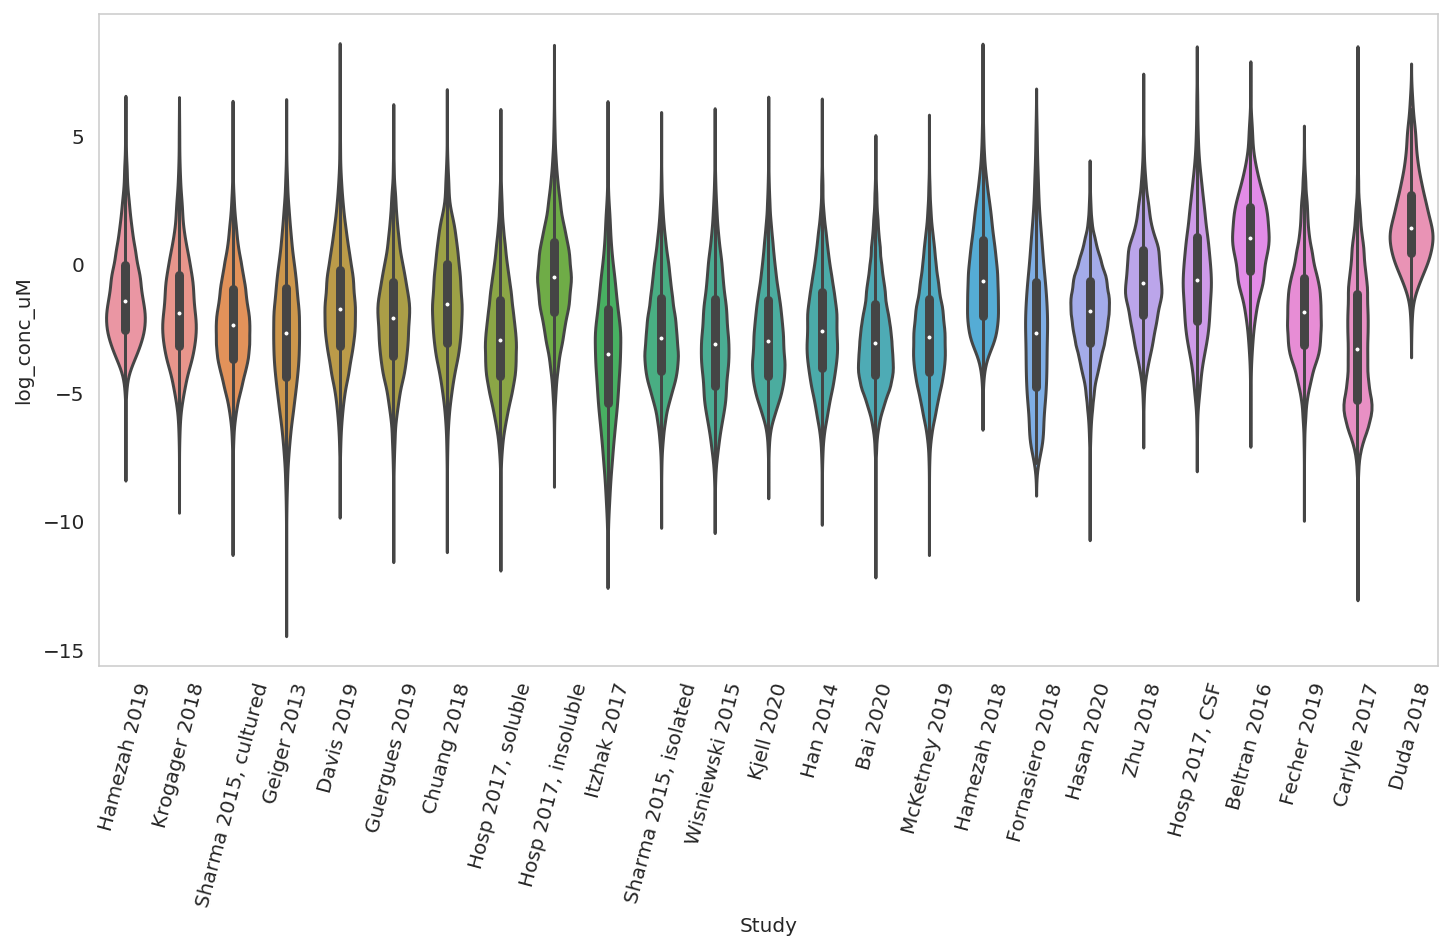

In [201]:
fig = plt.figure(figsize=(12, 6))


ax = sns.violinplot(x="Study", y="log_conc_uM", data=df)

ax.grid(False)
plt.xticks(rotation=75)
ax.set_ylabel('log_conc_uM')

plt.show()

In [202]:
with open('../data/3_df_with_conc_PerSampleNorm_9May2021.pkl','wb') as f:
    pkl.dump(df,f)